# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

In [4]:
IMG_SIZE = (299, 299)  # размер входного изображения сети

## Функции загрузки данных

In [5]:
import re
from random import shuffle
from glob import glob

train_files = glob('./data/train/*.jpg')
test_files = glob('./data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*dog\.\d+.*', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

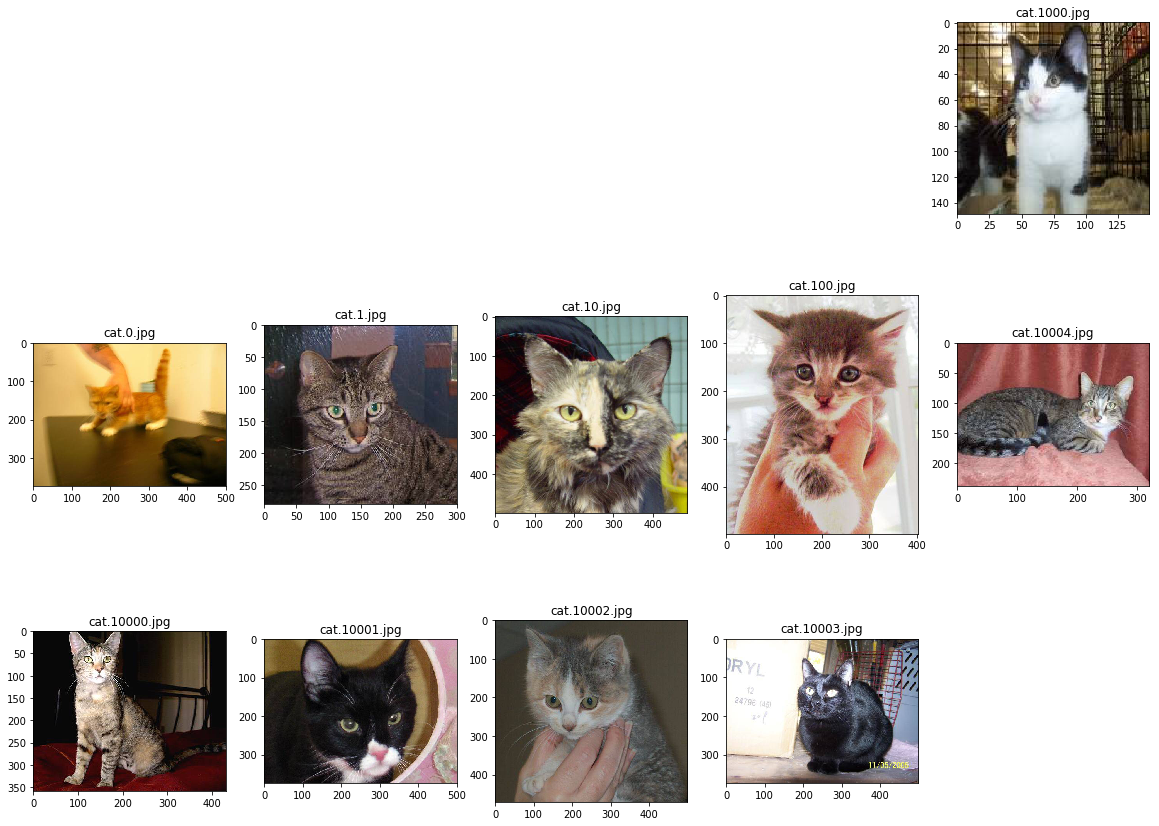

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('\\')[-1]);

## Загружаем предобученную модель

In [7]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = keras.applications.Xception(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [8]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

## Добавляем полносвязный слой

In [9]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(3,  # один выход
                       activation='relu',  # функция активации  
                       kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
                       kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Компилируем модель и запускаем обучение

In [11]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [12]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # 100 число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

In [13]:
%%time
# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
                    steps_per_epoch=10,  # число вызовов генератора за эпоху
                    epochs=100,  # число эпох обучения
                    validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 7s - loss: 0.8412 - acc: 0.5687 - val_loss: 0.5531 - val_acc: 0.7700
Epoch 2/100
10/10 [==============================] - 5s - loss: 0.6039 - acc: 0.4875 - val_loss: 0.5254 - val_acc: 0.8300
Epoch 3/100
10/10 [==============================] - 5s - loss: 0.4521 - acc: 0.6656 - val_loss: 0.3459 - val_acc: 0.9500
Epoch 4/100
10/10 [==============================] - 5s - loss: 0.2292 - acc: 0.9094 - val_loss: 0.3597 - val_acc: 0.9500
Epoch 5/100
10/10 [==============================] - 5s - loss: 0.3122 - acc: 0.9313 - val_loss: 0.4153 - val_acc: 0.7200
Epoch 6/100
10/10 [==============================] - 5s - loss: 0.4649 - acc: 0.6437 - val_loss: 0.3538 - val_acc: 0.6600
Epoch 7/100
10/10 [==============================] - 5s - loss: 0.2006 - acc: 0.9000 - val_loss: 0.2851 - val_acc: 0.9700
Epoch 8/100
10/10 [==============================] - 5s - loss: 0.1869 - acc: 0.9281 - val_loss: 0.2500 - val_acc: 0.9700
Epoch 9/100
10/10 [=====

10/10 [==============================] - 5s - loss: 0.2525 - acc: 0.9656 - val_loss: 0.2203 - val_acc: 0.9700
Epoch 68/100
10/10 [==============================] - 5s - loss: 0.2163 - acc: 0.9406 - val_loss: 0.5239 - val_acc: 0.9400
Epoch 69/100
10/10 [==============================] - 5s - loss: 0.2535 - acc: 0.9219 - val_loss: 0.2265 - val_acc: 0.9500
Epoch 70/100
10/10 [==============================] - 5s - loss: 0.0968 - acc: 0.9375 - val_loss: 0.2173 - val_acc: 0.9400
Epoch 71/100
10/10 [==============================] - 5s - loss: 0.1036 - acc: 0.9719 - val_loss: 0.2343 - val_acc: 0.9400
Epoch 72/100
10/10 [==============================] - 5s - loss: 0.1314 - acc: 0.9750 - val_loss: 0.1281 - val_acc: 0.9400
Epoch 73/100
10/10 [==============================] - 5s - loss: 0.1554 - acc: 0.9500 - val_loss: 0.1465 - val_acc: 0.9700
Epoch 74/100
10/10 [==============================] - 5s - loss: 0.1511 - acc: 0.9750 - val_loss: 0.2059 - val_acc: 0.9700
Epoch 75/100
10/10 [=========

In [15]:
model.save('my_model.h5')

## Предсказания на проверочной выборке

In [16]:
%%time
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

Wall time: 5min 1s


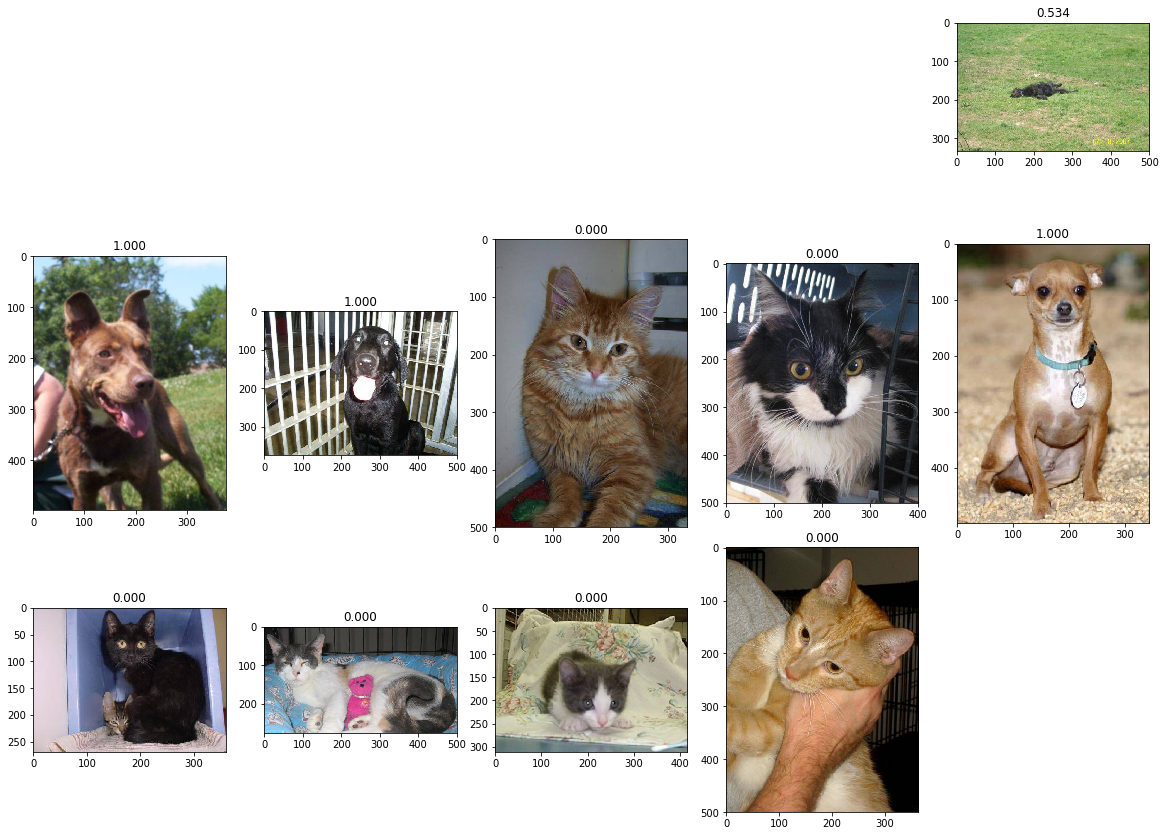

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [18]:
pred.shape

(12500, 1)

In [19]:
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\\d+)', path).group(0), np.clip(score,0.0125,0.9875) ))

In [ ]:
# LogLoss = 1.04979